In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as st
import numpy as np
%matplotlib inline

In [16]:
print(os.getcwd())
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

/Users/bglickenhaus/Documents/rescue_lab/cpr/rl/scripts


In [17]:
# Load breakevens for hard coded policies
with open('../../tailstorm_breakevens_all_gammas.pkl', 'rb') as f:
    breakevens = pd.read_pickle(f)
with open('../../nakamoto_breakevens_all_gammas.pkl', 'rb') as f:
    breakevens_nakamoto = pd.read_pickle(f)
# with open('../../breakevens_gamma_0.9.pkl', 'rb') as f:
#     breakevens_gamma_0_9 = pd.read_pickle(f)
# with open('../../breakevens_gamma_0.8.pkl', 'rb') as f:
#     breakevens_gamma_0_8 = pd.read_pickle(f)
# breakevens['gamma'] = 0.5
# breakevens_gamma_0_9['gamma'] = 0.9
# breakevens_gamma_0_8['gamma'] = 0.8
breakevens = pd.concat([breakevens, breakevens_nakamoto])

In [18]:
breakevens_nakamoto['gamma'].unique()

array([0. , 0.5, 0.9])

In [19]:
with open(f'../saved_models/model_evals_all_gammas.pkl', 'rb') as f:
    eval_df = pd.read_pickle(f)
with open(f'../saved_models/nakamoto_model_evals_all_gammas.pkl', 'rb') as f:
    nakamoto_eval_df = pd.read_pickle(f)
    # eval_df['gamma'] = 0.5
    breakevens = pd.concat([breakevens, eval_df, nakamoto_eval_df])

# with open(f'../saved_models/model_evals_gamma_0.9.pkl', 'rb') as f:
#     eval_df_gamma_0_9 = pd.read_pickle(f)
#     eval_df_gamma_0_9['gamma'] = 0.9
#     breakevens = pd.concat([breakevens, eval_df_gamma_0_9])
# with open(f'../saved_models/model_evals_gamma_0.8.pkl', 'rb') as f:
#     eval_df_gamma_0_8 = pd.read_pickle(f)
#     eval_df_gamma_0_8['gamma'] = 0.8
#     breakevens = pd.concat([breakevens, eval_df_gamma_0_8])
breakevens = breakevens.reset_index(drop=True)

In [20]:
breakevens.policy.unique()

array(['override-catchup', 'override-block', 'release-block', 'honest',
       'sapirshtein-2016-sm1', 'eyal-sirer-2014', 'simple', '2ys8h4ek',
       '2x496teq', 'nakamoto'], dtype=object)

In [21]:
breakevens.shape

(744000, 6)

In [22]:
display(breakevens.head())

,protocol,reward_scheme,alpha,policy,reward,gamma
0,tailstorm,constant,0.1,override-catchup,-17.826087,0.0
1,tailstorm,constant,0.1,override-catchup,-20.000000,0.0
2,tailstorm,constant,0.1,override-catchup,-20.000000,0.0
3,tailstorm,constant,0.1,override-catchup,-15.652174,0.0
4,tailstorm,constant,0.1,override-catchup,-20.000000,0.0


# 3 Questions
1) Hard-coded policy vs. RL Policy in same setting. Does RL beat hard coded?
   - If RL beats hard-coded, we can discard hard coded for future analysis
   - If RL is strictly worse than hard-coded, that sucks
   - If RL is equal to hard-coded, we feel confident in the calculated breakevens, but let's use RL since it's maybe more robust (doesn't impose priors)
   - How to measure: KS test establishes if the two distributions are different.
   - TODO: Run test on RL vs. Hard coded 
2) For a fixed policy, where is the breakeven point?
   - 
3) Across policies, is discount reward more secure than constant
   - Compare curve of best policy discount vs. constant

In [23]:
honest = breakevens[breakevens.policy == 'honest']
selfish = breakevens[breakevens.policy == '2ys8h4ek']
ttest_ind(honest.reward, selfish.reward, alternative="less", permutations=5)


Ttest_indResult(statistic=22.082643396245327, pvalue=1.0)

In [24]:
def holm_first_to_reject(ps, alpha=0.05):
    """This method uses Holm's procedure to identify the first hypothesis in a upward 
    structurally sufficient sequence of tests that can be rejected at level alpha.

    Args:
        ps: a upward strucuturally sufficient list of p-values
        alpha: the desired confidence level

    Returns:
        index of the first test that can be rejected at level alpha
    """
    order = np.argsort(ps)
    ps = np.array(ps)

    k = 0
    while ps[order][k] <= alpha / (len(ps) + k) and k < len(ps)-1:
        k += 1

    if k == 0:
        return None

    return min(order[:k])

In [25]:
t_test_df = dict(policy=[], t_test=[], p_value=[], gamma=[], alpha=[], reward_scheme=[])
breakevens_tailstorm = breakevens.loc[breakevens['protocol'] == 'tailstorm']
for key_a, grp_a in breakevens_tailstorm.groupby(['policy', 'reward_scheme', 'alpha', 'gamma']):
    for key_b, grp_b in breakevens_tailstorm.groupby(['policy', 'reward_scheme', 'alpha', 'gamma']):
        if key_a[0] == key_b[0]:
            continue
        if key_a[0] != "honest":
            continue
        if key_a[1] != key_b[1]:
            continue
        if key_a[2] != key_b[2]:
            continue
        if key_a[3] != key_b[3]:
            continue
        
        t_stat, p_value = ttest_ind(grp_a.reward, grp_b.reward, alternative="less")
        t_test_df['policy'].append(key_b[0])
        t_test_df['t_test'].append(t_stat)
        t_test_df['p_value'].append(p_value)
        t_test_df['reward_scheme'].append(key_b[1])
        t_test_df['alpha'].append(key_a[2])
        t_test_df['gamma'].append(key_a[3])
t_test_df = pd.DataFrame(t_test_df)
for key, grp in t_test_df.groupby(['policy', 'gamma', 'reward_scheme']):
    grp = grp.sort_values('alpha')
    print(grp)
    holms = holm_first_to_reject(grp.p_value)
    # if holms is not None:
    #     print(f"key: {key} holms:\n{grp.iloc[holms]}\n\n")
    # else:
    #     print(f"key: {key} holms:\nNone\n\n")
    print()

       policy     t_test       p_value  gamma  alpha reward_scheme
0    2x496teq   4.371855  9.999933e-01    0.0   0.10      constant
15   2x496teq   5.256377  9.999999e-01    0.0   0.11      constant
30   2x496teq   5.973245  1.000000e+00    0.0   0.12      constant
45   2x496teq   8.048957  1.000000e+00    0.0   0.13      constant
60   2x496teq   4.741307  9.999988e-01    0.0   0.14      constant
75   2x496teq   4.309795  9.999911e-01    0.0   0.15      constant
90   2x496teq   5.110839  9.999998e-01    0.0   0.16      constant
105  2x496teq   4.887707  9.999994e-01    0.0   0.17      constant
120  2x496teq   7.309747  1.000000e+00    0.0   0.18      constant
135  2x496teq  11.053578  1.000000e+00    0.0   0.19      constant
150  2x496teq  11.544329  1.000000e+00    0.0   0.20      constant
165  2x496teq  10.285145  1.000000e+00    0.0   0.21      constant
180  2x496teq  11.555173  1.000000e+00    0.0   0.22      constant
195  2x496teq  12.357197  1.000000e+00    0.0   0.23      cons

In [26]:
t_test_df['gamma'].unique()

array([0. , 0.5, 0.9])

In [27]:
holmses = []
for key, grp in t_test_df.groupby(['policy', 'gamma', 'reward_scheme']):
    grp = grp.sort_values('alpha')
    holms = holm_first_to_reject(grp.p_value)
    if holms is not None:
        holmses.append(grp.iloc[holms])

        print(f"key: {key} holms:\n{grp.iloc[holms]}\n\n")
    else:
        print(f"key: {key} holms:\nNone\n\n")
    print()

key: ('2x496teq', 0.0, 'constant') holms:
policy           2x496teq
t_test          -3.780704
p_value          0.000082
gamma                 0.0
alpha                0.46
reward_scheme    constant
Name: 540, dtype: object



key: ('2x496teq', 0.0, 'discount') holms:
policy           2x496teq
t_test          -3.494139
p_value          0.000247
gamma                 0.0
alpha                0.47
reward_scheme    discount
Name: 1155, dtype: object



key: ('2x496teq', 0.5, 'constant') holms:
policy           2x496teq
t_test          -3.342787
p_value          0.000429
gamma                 0.5
alpha                0.37
reward_scheme    constant
Name: 410, dtype: object



key: ('2x496teq', 0.5, 'discount') holms:
policy           2x496teq
t_test          -3.948222
p_value          0.000042
gamma                 0.5
alpha                0.41
reward_scheme    discount
Name: 1070, dtype: object



key: ('2x496teq', 0.9, 'constant') holms:
policy           2x496teq
t_test          -4.090915


In [28]:
df = pd.DataFrame(holmses)
df = df.loc[df['gamma'] != 0.8]
for key, grp in df.groupby(['gamma', 'reward_scheme']):
    grp.to_csv(f"{key}.csv")
    display(grp.sort_values('alpha'))

,policy,t_test,p_value,gamma,alpha,reward_scheme
391,2ys8h4ek,-3.289743,0.000517,0.0,0.36,constant
408,override-catchup,-4.067354,0.000034,0.0,0.37,constant
422,override-block,-3.926452,0.000059,0.0,0.38,constant
514,release-block,-4.590211,0.000004,0.0,0.44,constant
540,2x496teq,-3.780704,0.000082,0.0,0.46,constant


,policy,t_test,p_value,gamma,alpha,reward_scheme
1053,override-catchup,-4.651411,0.000003,0.0,0.40,discount
1066,2ys8h4ek,-3.900130,0.000051,0.0,0.41,discount
1097,override-block,-3.629143,0.000181,0.0,0.43,discount
1155,2x496teq,-3.494139,0.000247,0.0,0.47,discount


,policy,t_test,p_value,gamma,alpha,reward_scheme
396,2ys8h4ek,-3.667205,0.000128,0.5,0.36,constant
397,override-block,-4.205785,0.000020,0.5,0.36,constant
410,2x496teq,-3.342787,0.000429,0.5,0.37,constant
413,override-catchup,-4.880964,0.000001,0.5,0.37,constant
504,release-block,-3.511436,0.000276,0.5,0.43,constant


,policy,t_test,p_value,gamma,alpha,reward_scheme
1070,2x496teq,-3.948222,4.187266e-05,0.5,0.41,discount
1071,2ys8h4ek,-3.297871,5.027203e-04,0.5,0.41,discount
1087,override-block,-5.837635,1.068771e-08,0.5,0.42,discount
1088,override-catchup,-5.534586,4.906929e-08,0.5,0.42,discount


,policy,t_test,p_value,gamma,alpha,reward_scheme
205,2x496teq,-4.090915,2.305392e-05,0.9,0.23,constant
357,override-block,-3.432598,3.639284e-04,0.9,0.33,constant
416,2ys8h4ek,-5.123076,1.774393e-07,0.9,0.37,constant
418,override-catchup,-3.450357,3.420827e-04,0.9,0.37,constant
509,release-block,-4.267352,1.532308e-05,0.9,0.43,constant


,policy,t_test,p_value,gamma,alpha,reward_scheme
775,2x496teq,-3.368903,3.904448e-04,0.9,0.21,discount
1062,override-block,-3.296160,5.807811e-04,0.9,0.40,discount
1078,override-catchup,-3.521615,2.661903e-04,0.9,0.41,discount
1091,2ys8h4ek,-5.485948,2.551741e-08,0.9,0.42,discount


In [15]:
t_test_df.policy.unique()

array(['eyal-sirer-2014', 'sapirshtein-2016-sm1', 'simple'], dtype=object)

In [24]:
t_test_df = dict(policy=[], t_test=[], p_value=[], gamma=[], alpha=[], reward_scheme=[])
for key_a, grp_a in breakevens.groupby(['policy', 'reward_scheme', 'alpha', 'gamma']):
    for key_b, grp_b in breakevens.groupby(['policy', 'reward_scheme', 'alpha', 'gamma']):
        if key_a[0] == key_b[0]:
            continue
        if key_a[0] != "honest":
            continue
        if key_a[1] != key_b[1]:
            continue
        if key_a[2] != key_b[2]:
            continue
        if key_a[3] != key_b[3]:
            continue
        
        t_stat, p_value = ttest_ind(grp_a.reward, grp_b.reward, alternative="less")
        t_test_df['policy'].append(key_b[0])
        t_test_df['t_test'].append(t_stat)
        t_test_df['p_value'].append(p_value)
        t_test_df['reward_scheme'].append(key_b[1])
        t_test_df['alpha'].append(key_a[2])
        t_test_df['gamma'].append(key_a[3])
t_test_df = pd.DataFrame(t_test_df)

In [25]:
for key, grp in t_test_df.groupby(['policy', 'gamma', 'reward_scheme']):
    grp = grp.sort_values('alpha')
    grp['cum_t_test'] = grp['p_value'].cumprod()
    print(grp)
    print()

       policy     t_test        p_value  gamma  alpha reward_scheme  \
9    2x496teq  -2.718420   3.570806e-03    0.9   0.10      constant   
22   2x496teq   0.594939   7.237183e-01    0.9   0.11      constant   
35   2x496teq  -0.809337   2.096465e-01    0.9   0.12      constant   
48   2x496teq   0.589261   7.218210e-01    0.9   0.13      constant   
61   2x496teq   0.159968   5.634652e-01    0.9   0.14      constant   
74   2x496teq  -0.017738   4.929330e-01    0.9   0.15      constant   
87   2x496teq  -0.616503   2.691353e-01    0.9   0.16      constant   
100  2x496teq  -0.108101   4.570123e-01    0.9   0.17      constant   
113  2x496teq   1.790435   9.625441e-01    0.9   0.18      constant   
126  2x496teq  -0.002795   4.988864e-01    0.9   0.19      constant   
139  2x496teq  -1.934001   2.726930e-02    0.9   0.20      constant   
152  2x496teq  -2.067231   2.000648e-02    0.9   0.21      constant   
165  2x496teq  -2.597114   5.053396e-03    0.9   0.22      constant   
178  2

In [26]:
breakevens.head()

,protocol,reward_scheme,alpha,policy,reward,gamma
0,tailstorm,constant,0.1,override-catchup,-16.739130,0.5
1,tailstorm,constant,0.1,override-catchup,-16.739130,0.5
2,tailstorm,constant,0.1,override-catchup,-13.181818,0.5
3,tailstorm,constant,0.1,override-catchup,-15.000000,0.5
4,tailstorm,constant,0.1,override-catchup,-17.000000,0.5


In [27]:
gb = breakevens.groupby(['protocol', 'reward_scheme', 'alpha', 'policy', 'gamma']).mean()
gb_std = breakevens.groupby(['protocol', 'reward_scheme', 'alpha', 'policy', 'gamma']).std()

In [28]:
t_value = st.t.ppf(0.95, 99)

In [29]:
gb_diff = gb - (t_value * (gb_std / np.sqrt(100)))

In [30]:
gb_diff[gb_diff['reward'] > 0]

reward
protocol  reward_scheme alpha policy           gamma           
tailstorm constant      0.10  2x496teq         0.9     0.554947
                        0.12  honest           0.5     0.242425
                        0.16  2x496teq         0.9     0.029318
                        0.20  2x496teq         0.9     1.380966
                        0.22  2x496teq         0.9     1.830704
                        0.23  2x496teq         0.9     1.159947
                              honest           0.5     0.059335
                        0.24  2x496teq         0.9     1.023712
                        0.25  2x496teq         0.9     2.116069
                        0.26  2x496teq         0.9     1.253598
                        0.27  2x496teq         0.9     3.029466
                        0.28  2x496teq         0.9     2.392855
                              honest           0.8     0.358288
                        0.29  2x496teq         0.9     0.583338
                        0.31  2x496teq         0.9     2.980119
                        0.32  2x496teq         0.9     7.254727
                              override-block   0.9     1.523249
                        0.33  2x496teq         0.9     9.289616
                              override-block   0.8     1.342063
                                               0.9     8.205318
                        0.34  2x496teq         0.9    11.117692
                              override-block   0.8     3.546931
                                               0.9     5.171383
                        0.35  2x496teq         0.9    18.131368
                              2ys8h4ek         0.8     1.719323
                              override-block   0.8     4.912105
                                               0.9     7.638403
                              override-catchup 0.9     1.633960
                        0.36  2x496teq         0.9    23.618544
                              2ys8h4ek         0.5     1.375503
                                               0.8     2.109862
                              override-block   0.5     5.866798
                                               0.8     8.835721
                                               0.9    13.195090
                              override-catchup 0.5     2.253386
                                               0.8     1.276714
                                               0.9     4.878144
                        0.37  2x496teq         0.9    20.037871
                              2ys8h4ek         0.5     5.942911
                                               0.8     7.527085
                              override-block   0.5     8.648355
                                               0.8     8.169641
                                               0.9    13.193898
                              override-catchup 0.5     3.948934
                                               0.8     2.625217
                                               0.9     4.778236
                              release-block    0.5     0.144653
                        0.38  2x496teq         0.9    26.040655
                              2ys8h4ek         0.5    11.087705
                                               0.8     8.660128
                              override-block   0.5    14.413733
                                               0.8    15.770165
                                               0.9    14.743534
                              override-catchup 0.5     8.370444
                                               0.8     8.459126
                                               0.9     7.277386
                        0.39  2x496teq         0.9    31.975262
                              2ys8h4ek         0.5    12.100200
                                               0.8    16.144615
                              override-block   0.5    10.135049
                                               0.8    16.653038
                         

In [31]:
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 


NameError: name 'data' is not defined

In [15]:
breakevens['protocol'].unique()

array(['tailstorm', 'nakamoto'], dtype=object)

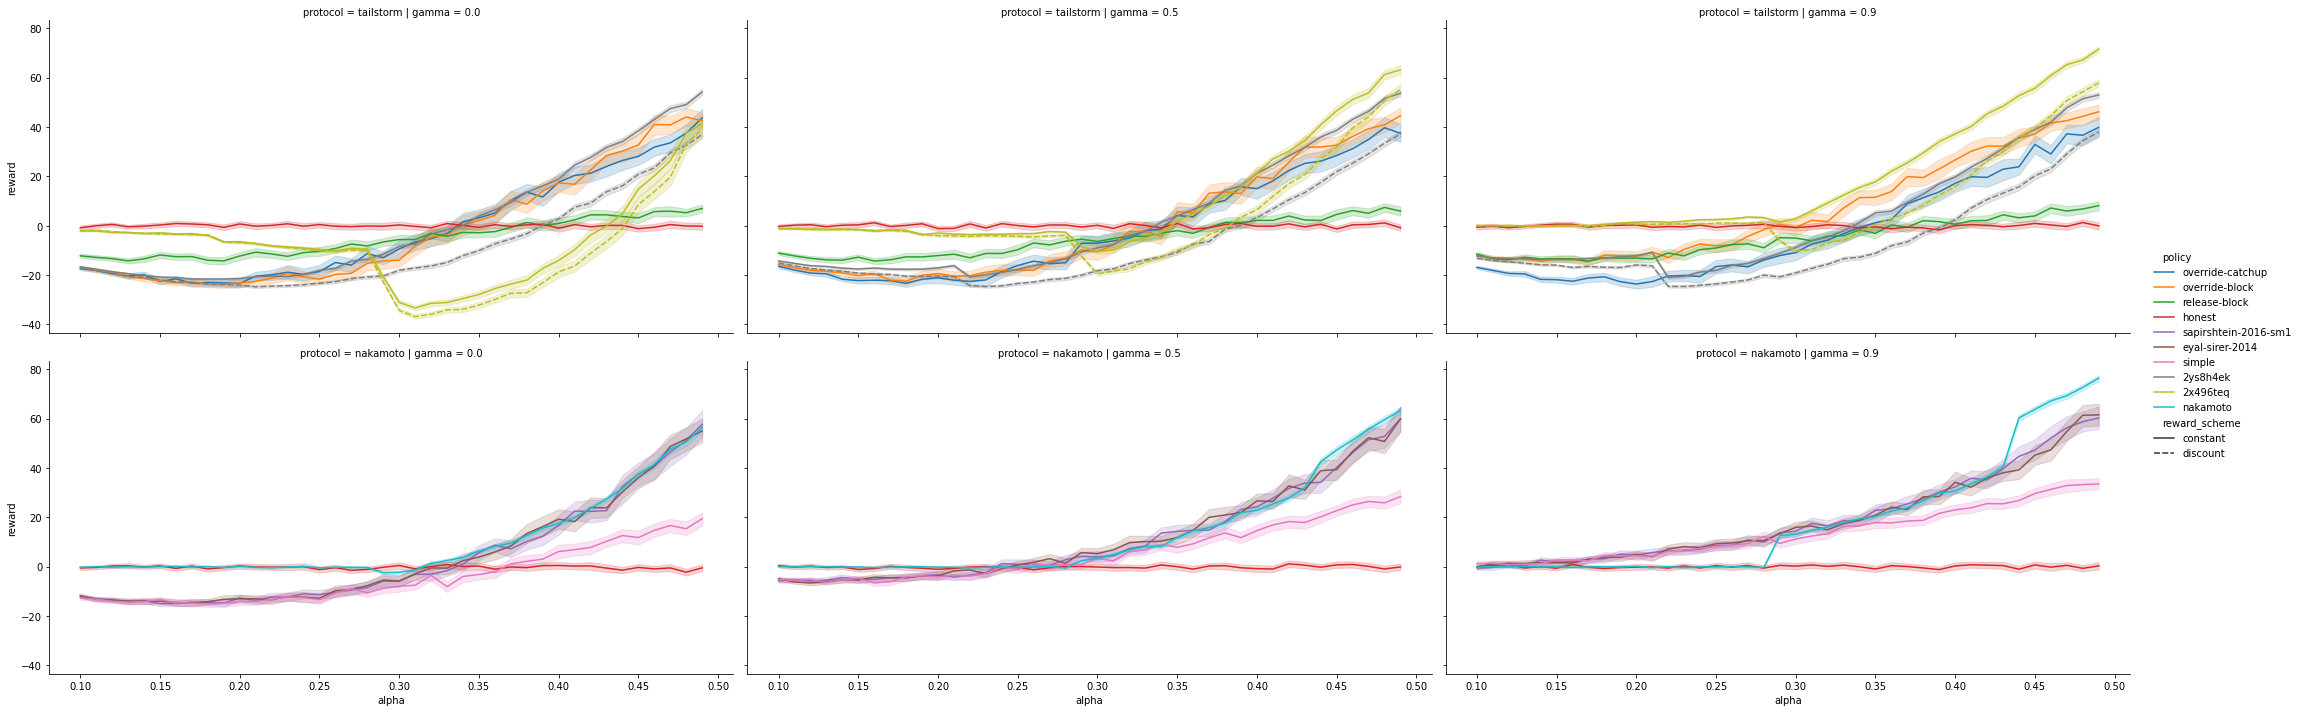

In [34]:
breakevens['excess reward'] = breakevens['reward']

sns.relplot(
    data=breakevens.loc[breakevens['gamma'] != 0.8],
    kind="line",
    x="alpha",
    y="excess reward",
    hue="policy",
    style="reward_scheme",
    row="protocol",
    col="gamma",
    aspect=2,
)

In [9]:
gb[gb['reward'] >= 0]

reward
protocol  reward_scheme alpha policy                     
tailstorm constant      0.12  honest             0.940685
                        0.14  honest             0.311272
                        0.15  3vnzkvsy           0.333211
                        0.16  honest             0.213649
                        0.17  3vnzkvsy           0.306212
                              honest             0.371470
                        0.20  honest             0.561288
                        0.21  3vnzkvsy           0.826282
                              honest             0.668881
                        0.22  3vnzkvsy           0.478973
                        0.23  honest             1.109656
                        0.25  3vnzkvsy           0.013671
                        0.26  3vnzkvsy           0.017552
                        0.28  3vnzkvsy           0.135707
                        0.30  honest             0.546090
                        0.31  3vnzkvsy           0.468361
                              honest             0.021924
                        0.33  3vnzkvsy           0.243104
                        0.34  2ys8h4ek           0.067353
                              3vnzkvsy           0.235255
                              honest             0.262185
                              override-block     3.015485
                              override-catchup   0.218417
                        0.35  2ys8h4ek           2.277294
                              3vnzkvsy           0.345546
                              honest             0.721667
                              override-block     2.061820
                              override-catchup   2.608256
                        0.36  2ys8h4ek           4.829975
                              honest             0.392533
                              override-block     8.593400
                              override-catchup   5.269548
                        0.37  2ys8h4ek           9.448182
                              override-block    11.833249
                              override-catchup   7.146293
                              release-block      1.823142
                        0.38  2ys8h4ek          14.176799
                              honest             0.316494
                              override-block    17.761645
                              override-catchup  11.544997
                              release-block      0.152041
                        0.39  2ys8h4ek          15.733646
                              override-block    13.529059
                              override-catchup  12.821143
                              release-block      0.899671
                        0.40  2ys8h4ek          17.257407
                              3vnzkvsy           1.265162
                              honest             0.256564
                              override-block    22.669112
                              override-catchup  15.362557
                              release-block      0.545483
                        0.41  2ys8h4ek          21.731180
                              honest             0.721692
                              override-block    24.871539
                              override-catchup  17.186318
                              release-block      2.593918
                        0.42  2ys8h4ek          24.365427
                              override-block    29.097994
                              override-catchup  25.090775
                              release-block      2.254329
                        0.43  2ys8h4ek          27.201453
                              3vnzkvsy           0.134432
                              override-block    28.952441
                              override-catchup  22.199771
                              release-block      3.621108
                        0.44  2ys8h4ek          31.573789
                              override-block    35.447387
                              override-catchup  2